# Sex and The City Script Text Analysis

The purpose of this project is the analysis of the entire script of the TV Show Sex and The City. Sex and the City is an American romantic comedy-drama television series created by Darren Star and produced by HBO. 

![Image of SATC](https://ichef.bbci.co.uk/news/660/cpsprodpb/15BD8/production/_101884098_satcfour_getty.jpg)

# Table of Content
0. [Downloads and Libraries](#lud)  
1. [Exploratory Data Analyis](#eda)  
2. [Text Preprocessing](#text-prepro)
   * [Tokenization](#tokenization)
3. [Natural Language Processing](#nlp)
    * [Lemmatization](#lemmatization)
    * [TF-IDF](#tfidf)
4. [Predictive Modeling](#prediction)
    * [Dimensionality Reduction](#dimensionality)   
        * [Preselection of Features](#pre-feat)   
        * [Principal Component Analysis](#pca) 
    * [Linear Regression](#linreg)
    * [Decision Tree Regressor](#regtrees) 
    * [Bagging Model](#bagging) 
    * [XGBoost](#xgb) 
    * [Prediction Including the Lines per Character ](#lpc)
    * [Model Comparison](#modelcomp)
5. [BONUS: Episode Lookup](#keyword)
    
   

## Downloads and Libraries <a class="anchor" id="lud"></a>

In [6]:
import pandas as pd
import math
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt

#types
from collections import Counter

# NLP library imports
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize

from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize

#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')

#Skelarn for TfIdf 
from sklearn.feature_extraction.text import TfidfVectorizer

#Sklearn model building and evaluation
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics 

#Sklearn for linear regression 
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

#DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import tree, export_graphviz
from sklearn.ensemble import RandomForestRegressor

import graphviz
from IPython.display import Image, display

# run this if grphviz throws error, after installing graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'

# PCA 
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

#xgb
import xgboost as xgb

#Plot Libraries
from  matplotlib import pyplot
import seaborn

#graphing
%matplotlib inline

#more vectorization
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

#IMBd API
#!pip install git+https://github.com/alberanid/imdbpy
from imdb import IMDb

## Exploratory Data Analyis <a class="anchor" id="eda"></a>

The present data set consists of 39208 lines of text with an average reating of 7.52 on IMDB. The poorest rating is 7.0, the highest rating is 8.8. The data set contains 94 unique episodes.

We first load the kaggle dataset ("satc_all_lines.csv"), which contains all lines of dialogue:

In [25]:
satc_all_lines = pd.read_csv("https://raw.githubusercontent.com/ranilovi/SATC_rating_prediction/master/SATC_all_lines.csv").drop(["Unnamed: 0"],axis=1)

Then we need the IMDb ratings (and possibly other information) for the episodes. 
We used ParseHub to generate "imdb_eps.csv" in order to collect all episode IDs, which are the unique identifiers used by the IMBd API to run requests. 

In [26]:
# get the imdb scraped information
eps = pd.read_csv("https://raw.githubusercontent.com/ranilovi/SATC_rating_prediction/master/imdb_eps.csv")
ep_ids = eps['ID']
# create an instance of the IMDb class
ia = IMDb()
# get the series
episodes =list(map(lambda x:ia.get_movie(x), ep_ids))
ratings = [x['rating'] for x in episodes]
eps['Rating'] = ratings

In [27]:
# merge the two datasets to add targets:
satc_all_lines_w_rating = pd.merge(satc_all_lines, eps, how='left', 
                                   left_on=['Season', 'Episode'],right_on=['Season', 'Episode'])
satc_all_lines_w_rating['Episode'] = satc_all_lines_w_rating['Episode'].apply(lambda x: str(x).zfill(2))

In [28]:
#satc_all_lines_w_rating = pd.read_csv("satc_all_lines_w_rating.csv").drop(["Unnamed: 0"],axis=1)
#create col with season and episode
satc_all_lines_w_rating['S_E'] = satc_all_lines_w_rating['Season'].astype(int).astype(str)+"_"+satc_all_lines_w_rating['Episode']
satc_all_lines_w_rating.head()

,Season,Episode,Speaker,Line,date_job,ep_data_name,ep_data_url,ID,Rating,S_E
0,1,01,Carrie,"Once upon a time, an English journalist came t...",NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_01
1,1,01,Carrie,Elizabeth was attractive and bright.,NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_01
2,1,01,Carrie,Right away she hooked up with one of the city'...,NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_01
3,1,01,Tim,The question remains Is this really a company ...,NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_01
4,1,01,Carrie,"Tim was 42, a wellliked and respected investme...",NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_01


In [29]:
satc_all_lines_w_rating.describe()

,Season,ID,Rating
count,39208.000000,39208.000000,39208.000000
mean,3.657289,698653.514232,7.531769
std,1.692661,26.903364,0.281950
min,1.000000,698608.000000,7.000000
25%,2.000000,698631.000000,7.300000
50%,3.000000,698653.000000,7.500000
75%,5.000000,698676.000000,7.700000
max,6.000000,698701.000000,8.800000


In [30]:
len(satc_all_lines_w_rating['S_E'].unique())

93

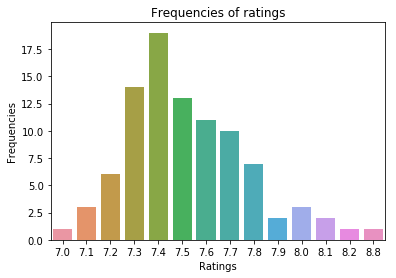

In [31]:
# Plotting rating distribution
X_ratings = satc_all_lines_w_rating.groupby(['S_E']).min().Rating.value_counts()
x = sns.barplot(X_ratings.index,X_ratings)
x.set(xlabel='Ratings',ylabel='Frequencies',title='Frequencies of ratings'.format(satc_all_lines_w_rating.shape[0]))
plt.show()
#X_ratings

## Text Preprocessing <a class="anchor" id="#text-prepro"></a>

In order to perform an analysis of the present text, we pre-process the text (represented by seperate lines in our data set). We bring all words to lowercase to be able to compare words across their position in a sentence ("Hello" and "hello" should be the same word). We furthermore strip all text of special characters. 

In [32]:
#text transformation
satc_all_lines_w_rating["cleaned"] = satc_all_lines_w_rating.Line.tolist()
#all to lowercase 
satc_all_lines_w_rating.cleaned = [str(line).lower() for line in satc_all_lines_w_rating.cleaned]

#remove special chars
chars_remove = ["@", "/", "#", ".", ",", "!", "?", "(", ")", "-", "_","’","'", "\"", ":"]
trans_dict = {initial:" " for initial in chars_remove}
satc_all_lines_w_rating.cleaned = [line.translate(str.maketrans(trans_dict)) for line in satc_all_lines_w_rating.cleaned]
satc_all_lines_w_rating.head()

print("Before transformation:",satc_all_lines_w_rating.Line[0],"\n After transformation:", satc_all_lines_w_rating.cleaned[0])
satc_all_lines_w_rating.head()

Before transformation: Once upon a time, an English journalist came to New York. 
 After transformation: once upon a time  an english journalist came to new york 


,Season,Episode,Speaker,Line,date_job,ep_data_name,ep_data_url,ID,Rating,S_E,cleaned
0,1,01,Carrie,"Once upon a time, an English journalist came t...",NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_01,once upon a time an english journalist came t...
1,1,01,Carrie,Elizabeth was attractive and bright.,NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_01,elizabeth was attractive and bright
2,1,01,Carrie,Right away she hooked up with one of the city'...,NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_01,right away she hooked up with one of the city ...
3,1,01,Tim,The question remains Is this really a company ...,NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_01,the question remains is this really a company ...
4,1,01,Carrie,"Tim was 42, a wellliked and respected investme...",NaN,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_01,tim was 42 a wellliked and respected investme...


### Tokenization <a class="anchor" id="tokenization"></a>
We then tokenize the text, this means, we break up the text into invidiual tokens. We are using the NLTK tokenize package and are splitting sentences up into single tokens using word_tokenize. The method invoked by word_tokenize is using the "Treebank tokenizer", a tokenizer that uses regular expressions to tokenize text.

After tokenization, we remove stopwords from the text, using the english stopwords from NLTK. Stopwords are language specific word that carry no meaning for the purpose of a text analyis.

In [33]:
print(str(len(stopwords.words("english")) ) +" stopwords are included in the stopwords corpus for the English language, containing words such as" + str(stopwords.words("english")[20:34]))

179 stopwords are included in the stopwords corpus for the English language, containing words such as['himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs']


In [34]:
#We are using NLKT tokenizer to split all text up into individual tokens
satc_all_lines_w_rating["tokenized"] = [word_tokenize(line) for line in satc_all_lines_w_rating.cleaned]

#Removing stopwords for topic extraction using nltk stopwords library
stopw = stopwords.words('english')
satc_all_lines_w_rating["w_o_stopwords"] = [[token for token in line if token not in stopw if len(token)>2] for line in satc_all_lines_w_rating.tokenized]
satc_all_lines_w_rating.head()

print("Before transformation:",satc_all_lines_w_rating.Line[0],"\n After transformation:", satc_all_lines_w_rating.w_o_stopwords[0])

Before transformation: Once upon a time, an English journalist came to New York. 
 After transformation: ['upon', 'time', 'english', 'journalist', 'came', 'new', 'york']


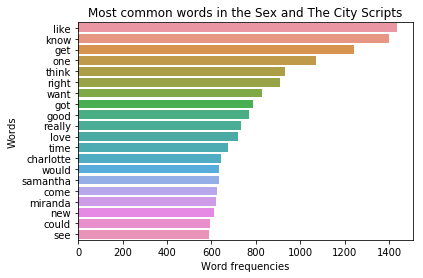

In [38]:
all_words = []
for line in satc_all_lines_w_rating["w_o_stopwords"]:
    for word in line:
        all_words.append(word)

dist = nltk.FreqDist(all_words)
X = [nb[1] for nb in dist.most_common(20)]
y = [nb[0] for nb in dist.most_common(20)]
x = sns.barplot(np.array(X),np.array(y))
x.set(xlabel='Word frequencies',ylabel='Words',title='Most common words in the Sex and The City Scripts')
plt.show()

In [39]:
#saving tokenized data set
#satc_all_lines_w_rating.to_csv("satc_all_lines_w_rating_tokenized.csv")

## Natural Language Processing <a class="anchor" id="nlp"></a>
### Lemmatization <a class="anchor" id="lemmatization"></a>

In order to combine words that represent the same meaning, we are using the WordNetLemmatizer() to transform our corpus. "WordNet® is a large lexical database of English. Nouns, verbs, adjectives and adverbs are grouped into sets of cognitive synonyms (synsets), each expressing a distinct concept. Synsets are interlinked by means of conceptual-semantic and lexical relations." [Source: https://wordnet.princeton.edu]

In [40]:
# apply lemmatization from wordnet in order to merge words that come from the same meaning .- for example, "friend" and "friends" should be counted as the same word

def lemmatize(tokens):
    tokens = [WordNetLemmatizer().lemmatize(WordNetLemmatizer().lemmatize(WordNetLemmatizer().lemmatize(token,pos='a'),pos='v'),pos='n') for token in tokens]
    return tokens  

satc_all_lines_w_rating["lemmatized"] = [lemmatize(line) for line in satc_all_lines_w_rating.w_o_stopwords]

In [42]:
#look at the difference in words 
print(satc_all_lines_w_rating.w_o_stopwords[0:5])
print(satc_all_lines_w_rating.lemmatized[0:5])

0    [upon, time, english, journalist, came, new, y...
1                      [elizabeth, attractive, bright]
2    [right, away, hooked, one, city, typically, el...
3           [question, remains, really, company, want]
4    [tim, wellliked, respected, investment, banker...
Name: w_o_stopwords, dtype: object
0    [upon, time, english, journalist, come, new, y...
1                      [elizabeth, attractive, bright]
2    [right, away, hook, one, city, typically, elig...
3            [question, remain, really, company, want]
4    [tim, wellliked, respect, investment, banker, ...
Name: lemmatized, dtype: object


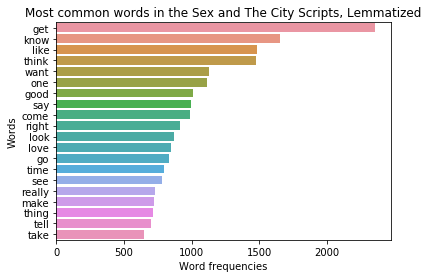

In [43]:
all_words = []
for line in satc_all_lines_w_rating["lemmatized"]:
    for word in line:
        all_words.append(word)

dist = nltk.FreqDist(all_words)
X = [nb[1] for nb in dist.most_common(20)]
y = [nb[0] for nb in dist.most_common(20)]
x = sns.barplot(np.array(X),np.array(y))
x.set(xlabel='Word frequencies',ylabel='Words',title='Most common words in the Sex and The City Scripts, Lemmatized')
plt.show()

### TF-IDF <a class="anchor" id="tfidf"></a>


Tf-Idf is a widely used statistic in the field of information retreival, used to quantify the relevance of a query or key word to a document inside a corpus.  It is commonly used in search engine optimization and text mining. The statistic is designed to assigns higher relevance to a term if it occurs often in the document, but penalize it if it occus in many different documents, i.e. it is not unique or specific to one or few documents. The general formula to compute the Tf-Idf score for term _t_ and documet _d_ in corpus _D_ is:

<center> 
$tf.idf(t,d,D)=tf(t,d)*idf(t,D)$ <br><br>
$=\frac{n(t,d)}{N(d)}*log\frac{|D|}{d(t)}$<br><br>
</center>
where:<br><br>
$tf(t,d)$ is the term frequency function<br><br>
$idf(t,D)$ is the inverse document frequency function<br><br>
$n(t,d)$ is the number of times t occurs in d<br><br>
$N(d)$ is the number of unique terms in d<br><br>
$d(t)$ is the number of documents in D which contain t<br><br>

We are using a TFIDF statistic across our data set in order to understand, which words are significant in describing the content per episode. In our dataset, a document are all the lines of text spoken in one episode, and the corpus are all episodes together. 

In [44]:
#group by episode to define one episode as one document for tf-idf

#initizalize new df
satc_text_per_episode = pd.DataFrame(
    columns=list(satc_all_lines_w_rating)[5:10])

#init
current_s_e = "1_01"
all_lines = []
#collect all speakers per episode 
all_speakers = []
carrie = 0
samantha = 0
miranda = 0
charlotte = 0
stanford = 0

for index, row in satc_all_lines_w_rating.iterrows():
        if(row.S_E == current_s_e):
            #we use the lemmatized version of the lines, change here for different choice of text preprocessing
            all_lines.append(row.lemmatized)
            all_speakers.append(row.Speaker)
            
        if row.S_E != current_s_e:
            #flatten all tokens for previous episode and add them to the dataframe
            flat_all_lines = [word for line in all_lines for word in line]
            
            #count lines per main character 
            for name in all_speakers:
                if name == "Carrie":
                    carrie = carrie + 1
                if name == "Samantha":
                    samantha = samantha + 1
                if name == "Miranda":
                    miranda = miranda + 1
                if name == "Charlotte":
                    charlotte = charlotte + 1   
        
            
            
            #add a new row to new df, taking the information from the index-1 (the last s_e)
            satc_text_per_episode = satc_text_per_episode.append({'ep_data_name': satc_all_lines_w_rating.ep_data_name[index-1],
                                                                  'ep_data_url': satc_all_lines_w_rating.ep_data_url[index-1],
                                                                  'ID': satc_all_lines_w_rating.ID[index-1],
                                                                  'Rating': satc_all_lines_w_rating.Rating[index-1],
                                                                  'S_E': satc_all_lines_w_rating.S_E[index-1],
                                                                  'all_text': flat_all_lines,
                                                                  'all_speakers': all_speakers,
                                                                  'lines_carrie': carrie,
                                                                  'lines_samantha': samantha,
                                                                  'lines_charlotte':charlotte,
                                                                  'lines_miranda': miranda,
                                                                
                                                                 
                                                                 }, ignore_index=True)
        
            #update vars
            all_lines = []
            all_speakers = []
            carrie = 0
            samantha = 0
            miranda = 0
            charlotte = 0
            stanford = 0
            current_s_e = row.S_E


satc_text_per_episode.head()

,ep_data_name,ep_data_url,ID,Rating,S_E,all_speakers,all_text,lines_carrie,lines_charlotte,lines_miranda,lines_samantha
0,Sex and the City,https://www.imdb.com/title/tt0698663/?ref_=tte...,698663,7.4,1_01,"[Carrie, Carrie, Carrie, Tim, Carrie, Carrie, ...","[upon, time, english, journalist, come, new, y...",150.0,33.0,29.0,26.0
1,Models and Mortals,https://www.imdb.com/title/tt0698649/?ref_=tte...,698649,7.4,1_02,"[Carrie, Nick, Nick , Miranda , Nick , Nick , ...","[date, nick, fairly, successful, sport, agent,...",109.0,6.0,9.0,25.0
2,Bay of Married Pigs,https://www.imdb.com/title/tt0698618/?ref_=tte...,698618,7.4,1_03,"[Carrie, Carrie, Carrie, Carrie, Carrie, Carri...","[friend, patience, husband, invite, hampton, w...",137.0,19.0,39.0,27.0
3,Valley of the Twenty-Something Guys,https://www.imdb.com/title/tt0698697/?ref_=tte...,698697,7.5,1_04,"[Carrie, Carrie, Carrie, Carrie, Carrie, Carri...","[seem, meet, everywhere, street, corner, party...",174.0,41.0,24.0,28.0
4,The Power of Female Sex,https://www.imdb.com/title/tt0698688/?ref_=tte...,698688,7.3,1_05,"[Carrie, Carrie, Samantha, Samantha, Carrie, S...","[host, balzac, overnight, become, restaurant, ...",138.0,18.0,30.0,37.0


In [45]:
##create the tfidf matrix
vect = TfidfVectorizer(analyzer ='word',ngram_range=(1,1),encoding='latin1')
vect_transformed = vect.fit_transform([text for text in satc_text_per_episode['all_text'].astype(str)])

feature_names = np.array(vect.get_feature_names())

satc_tfidf = pd.concat([satc_text_per_episode[['S_E','ep_data_name','ID','Rating']],
                        pd.DataFrame(vect_transformed.todense(), columns = feature_names)],axis=1)

#create a second dataframe containing the lines per character: 
satc_tfidf_LPC = pd.concat([satc_text_per_episode[['S_E','ep_data_name','ID','Rating','lines_carrie','lines_samantha','lines_charlotte','lines_miranda']],
                        pd.DataFrame(vect_transformed.todense(), columns = feature_names)],axis=1)

satc_tfidf.head()

,S_E,ep_data_name,ID,Rating,000,00am,00amer,00pm,100,1000,...,zoie,zone,zoo,zooey,zorro,zsa,zsu,zucchini,zygote,éclairs
0,1_01,Sex and the City,698663,7.4,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1_02,Models and Mortals,698649,7.4,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1_03,Bay of Married Pigs,698618,7.4,0.016817,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1_04,Valley of the Twenty-Something Guys,698697,7.5,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1_05,The Power of Female Sex,698688,7.3,0.068272,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Exploring the tf-idf matrix by checking some of the highest and lowest scores:

In [46]:
#some words with smallest and largest tfids
sorted_tfidf_index = vect_transformed.max(0).toarray()[0].argsort()
print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['tiny' 'whenever' 'track' 'round' 'perform' 'impossible' 'obvious'
 'exact' 'ahead' 'replace']

Largest tfidf: 
['laney' 'threesome' 'pattern' 'phil' 'fake' 'model' 'yankee' 'zsa' 'soul'
 'javier']


We want to explore if there are any interesting correlations between the ratings and tf-idf scores of individual tokens (features). Since there are more than 9,000 features, we'll look at the correlation matrix of the 10 most correlated words:

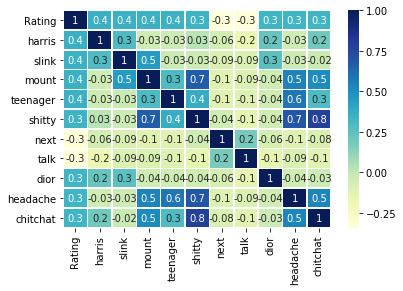

In [47]:
cols = satc_tfidf.ix[:,3:].corr().abs().sort_values('Rating', ascending = False).index[:11]

sns.heatmap(satc_tfidf[cols].corr(),cmap="YlGnBu", annot=True, fmt=".1g", linewidths = 0.5)

## Predictive Modeling <a class="anchor" id="prediction"></a>

### Model Comparison - Note

In order to compare the performance of different models, using different kinds of preprocessing and features, we designed the function evaluate_model in the process in comparing them. We will present different models and show their predictive capability by comparing error metrics, as well as looking at prediction precision with plots and other visual aids (such as a modeling of regression trees later on).

As the key metric to compare models with we are using the mean squared error regression loss. 

In [48]:
# evaluate_model takes as argument
# modelname a string - to create an easy overview for final comparison 
# a model as provided by the sklearn library
# number of features: as selected with the function get_features based on their tfdif score 
# pca_dim: number of dimensions kept in pca, can be set to None if no PCA
# df: should be satc_tfidf or satc_tfidf_LPC
# LPC: boolean with default falue False, set to True if you want to include the lines per character as a feature 

# returns 
# results - dataframe containing results from 10 iterations
# model_details_and_averages - description of the input and average over ten iterations 
# target_test,target_pred_test - y* and y_pred for the test set

def evaluate_model(modelname,model,number_of_features,pca_dim,df,LPC=False):
    
    #get the words that we will look at in the analysis
    selected_words = get_features('tfidf',number_of_features)
    
    #define the features and targets 
    if LPC == False:
        features = df[df.columns[4:]].filter(selected_words,axis=1).values
        target= df['Rating'].values
    
    #if we also use lines per character, we need to select different cols
    if LPC == True:
        features = df[df.columns[8:]].filter(selected_words,axis=1).values
        target= df['Rating'].values
    

    #if pca_dim != None, create the pca model 
    if pca_dim: 
        pca = PCA(n_components=pca_dim)

    
    results={}
    #labels = satc_tfidf['Rating'].unique()
    num_run = 20

    #get ten results to account for randomness 
    for i in range (num_run):

        # separate datasets into training and test datasets once, no folding
        features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3)
        
        #if pca, apply the dim reduction 
        if pca_dim: 
                features_train = pca.fit_transform(features_train)
                features_test = pca.transform(features_test)

        # train the features and target datasets and fit to a model
        trained_model = model.fit(features_train, target_train)


        # predict target with feature test set using trained model
        target_pred_train = list(trained_model.predict(features_train))
        target_pred_test = list(trained_model.predict(features_test))

        results[i]=[metrics.mean_squared_error(target_test, target_pred_test),
                metrics.mean_absolute_error (target_test, target_pred_test),
                metrics.explained_variance_score(target_test, target_pred_test),
                metrics.r2_score(target_test, target_pred_test),
                   ]

    results = pd.DataFrame.from_dict(data=results,orient='index',columns=['MSE','MAbsE', 'Explained_variance_score','R_squared']) 
    model_details_and_averages = [
    str(modelname),
    number_of_features,pca_dim,
    results.MSE.mean(),
    results.MAbsE.mean(),
    results.Explained_variance_score.mean(),
    results.R_squared.mean(),
    ]

    
    return results,model_details_and_averages, target_test,target_pred_test

#evaluate model without lines per char
#evaluate_model("Lasso",lasso_model,50,50,satc_tfidf)[1]
#evaluate model with lines per char
#evaluate_model("Lasso",lasso_model,50,50,satc_tfidf_LPC,True)[1]

### Dimensionality Reduction  <a class="anchor" id="dimensionality"></a> 

Calculating the TF-IDF scores for each word that occurs in the data set, we end up with a matrix of the shape 93x8926, 93x8930 if we want to includge the lines spoken per character per episode in our data set. We are dealing with p>>n, a data set where the number of then the number of variables is much higher then the number of observations. We furthermore have an extremely sparse matrix because of the nature of the TF-IDF matrix. 

We are going to look at different ways to reduce the dimensionality: 
 + Preselection of features based on their TF-IDF scores
 + Dimensionality Reduction based on Principal Component Analysis


In [49]:
satc_tfidf.shape

(92, 9692)

In [50]:
satc_tfidf_LPC.shape

(92, 9696)

#### Preselection of Features  <a class="anchor" id="pre-feat"></a> 

In [73]:
def get_features(method ='tf', k=100):
    k=k
    if (method == 'tfidf'):
        #getting topK highest tfidf words
        top_k = feature_names[sorted_tfidf_index[:-(k+1):-1]]
    elif (method == 'tf'):
        #topK most common words
        counter = Counter([item for sublist in satc_text_per_episode['all_text'] for item in sublist])
        top_k = counter.most_common(k)
    else:
        top_k = None
        print("Bad input!! Choose tf or tfidf as first arg")
    
    return list(top_k)

In [74]:
features_words = get_features('tfidf',50)
print(features_words)

['laney', 'threesome', 'pattern', 'phil', 'fake', 'model', 'yankee', 'zsa', 'soul', 'javier', 'church', 'ghost', 'sam', 'shrink', 'honeymoon', 'jim', 'postit', 'sandwich', 'cheat', 'rabbit', 'jeremy', 'whore', 'fetish', 'karma', 'weight', 'gay', 'raw', 'myth', 'bitsy', 'paris', 'atlantic', 'madeline', 'stewardess', 'shoe', 'dildo', 'berger', 'mao', 'sailor', 'change', 'ray', 'lsland', 'vogue', 'game', 'ball', 'money', 'email', 'freak', 'nina', 'marry', 'ovary']


 #### Principal Component Analysis  <a class="anchor" id="pca"></a> 
 
Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The resulting vectors (each being a linear combination of the variables and containing n observations) are an uncorrelated orthogonal basis set.

We are dealing with 9000 different dimensions on the variable side, of which we can probably disregard most: most tf-idf entries in the matrix carry little information. We are therefore interested in reducing the dimensionality of our predictor variables. 

### Linear Regression <a class="anchor" id="linreg"></a>

To get an idea of a base MSE that we can achieve with our data set, we perform a linear regression that uses the least squares metric. We use this model to perform a grid search: We look at the MSE that we achieve with our data set taking in to account different number of features (from 100 - 9000) and different number of PCA dimensions. By doing so, we can better understand which method of dimensionality reduction serves our objective of creating a predictive model for the given data set best.

#### Linear Regression, no Regularization

Text(0, 0.5, 'y_star')

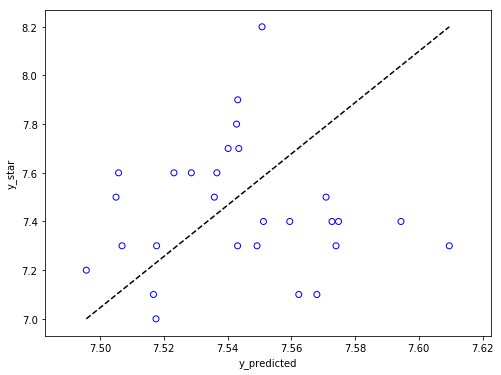

In [75]:
linear_regression = LinearRegression() 

#Linear Regression with all features and 50 PCA Dimensions
eval_linreg = evaluate_model("linreg",linear_regression,900,10,satc_tfidf)
y_star,y_pred = eval_linreg[2:4]

# Plot the predicted vs the actual medv response
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.scatter(y_pred,y_star , facecolor='None', edgecolor='b')
# add a reference unity line
ax.plot([min(y_pred), max(y_pred)], [min(y_star), max(y_star)], linestyle='--', color='k');
ax.set_xlabel('y_predicted')
ax.set_ylabel('y_star')

In [76]:
#gridsearch_linreg = pd.DataFrame(columns=["Name","features","pca_dim",'MSE','MAbsE', 'Explained_variance_score','R_squared'])

#for pcadim in range(0,50,10):
 #   if pcadim == 0:
  #      pcadim = None 
   # for featuredim in range (100,9000,500):
    #    gridsearch_linreg.loc[len(gridsearch_linreg)] = evaluate_model("linear_reg",linear_regression,featuredim,pcadim,satc_tfidf)[1]

#gridsearch_linreg.to_csv("gridsearch_linreg.csv")

In [77]:
#gridsearch_linreg.head()
gridsearch_linreg= pd.read_csv("https://raw.githubusercontent.com/ranilovi/SATC_rating_prediction/master/gridsearch_linreg.csv").drop(["Unnamed: 0"],axis=1)

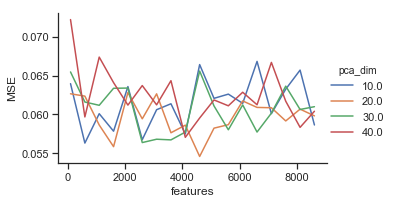

In [78]:
seaborn.set(context="notebook",style='ticks')

fg = seaborn.FacetGrid(data=gridsearch_linreg, hue='pca_dim', 
                       #hue_order=_genders, 
                       aspect=1.61)
fg.map(pyplot.plot, 'features', 'MSE').add_legend()

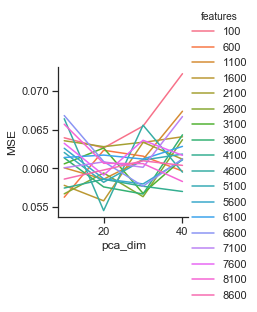

In [79]:
fg = seaborn.FacetGrid(data=gridsearch_linreg, hue='features',)
fg.map(pyplot.plot, 'pca_dim', 'MSE').add_legend()

In [80]:
#20 best mse 
gridsearch_linreg.sort_values("MSE", inplace=True)

gridsearch_linreg.head()
#we get smallest mse 0.054556

,Name,features,pca_dim,MSE,MAbsE,Explained_variance_score,R_squared
45,linear_reg,4600,20.0,0.054556,0.189874,-0.022672,-0.077935
39,linear_reg,1600,20.0,0.055822,0.192558,-0.017447,-0.083173
19,linear_reg,600,10.0,0.056286,0.198081,0.000750,-0.063915
59,linear_reg,2600,30.0,0.056352,0.187811,0.008375,-0.045383
61,linear_reg,3600,30.0,0.056699,0.194365,-0.023472,-0.104713


By doing a grid search for all possible combinations of dimension and PCA and ploting them against the MSE, we cannot identify a pattern. Since we prefer a less complex model to a more complex one, if they both possess the same explanatory power, we do another grid search looking at a small number of features and all PCA dimensions.  We get the best results for PCA dimensions <20, regardless of the number of features taken into account. This makes sense, since applying a PCA will modify the variables in a way that we expect to be ignoring most features anyway.

We get an MSE of 0.053225, with an absolute Explained Erorr of around 0.186675 is our baseline score to judge further models. 



In [81]:
gridsearch_linreg_small = pd.DataFrame(columns=["Name","features","pca_dim",'MSE','MAbsE', 'Explained_variance_score','R_squared'])

for featuredim in range (10,500,10):
    for pcadim in range(0,50,10):
        if featuredim < pcadim:
            pcadim = featuredim
        if pcadim == 0:
            pcadim = None 
        gridsearch_linreg_small.loc[len(gridsearch_linreg_small)] = evaluate_model("linear_reg",linear_regression,featuredim,pcadim,satc_tfidf)[1]

In [96]:
gridsearch_linreg_small.sort_values("MSE", inplace=True)
gridsearch_linreg_small.head()

,Name,features,pca_dim,MSE,MAbsE,Explained_variance_score,R_squared
97,linear_reg,200,20,0.053843,0.189002,-0.057870,-0.094228
213,linear_reg,430,30,0.055832,0.189891,-0.060653,-0.119618
46,linear_reg,100,10,0.056253,0.190228,-0.020523,-0.059272
118,linear_reg,240,30,0.056317,0.190691,-0.040912,-0.138214
94,linear_reg,190,40,0.056854,0.191403,-0.057828,-0.106517


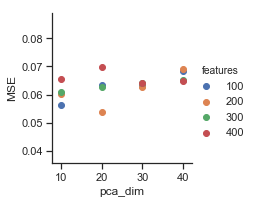

In [83]:
fg3 = seaborn.FacetGrid(data=
gridsearch_linreg_small[gridsearch_linreg_small["features"]%100 == 0], hue='features')
fg3.map(pyplot.scatter, 'pca_dim', 'MSE').add_legend()

#### Penalized Regression using Lasso

As we are using sparse data, it makes sense to use regularization methods such a Lasso or Ridge regression. We are using the sklearn Lasso linear model with iterative fitting along a regularization path. The best model (with the best regularization parameter) is selected by cross-validation.

The optimization objective for Lasso is:

(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

We get a similar MSE (0.053387) as before for 500 features. 

In [98]:
#lasso_model = LassoCV(n_alphas=100, alphas=[.01,.1,1,10,100]) 
lasso_model = LassoCV() 

gridsearch_lasso = pd.DataFrame(columns=["Name","features","pca_dim",'MSE','MAbsE', 'Explained_variance_score','R_squared'])

#pca dim should be in between 20 and 30 
featuredim = 500 

for pcadim in range(0,30):
    if pcadim == 0:
            pcadim = None 
    gridsearch_lasso.loc[len(gridsearch_lasso)] = evaluate_model("lasso_model",lasso_model,featuredim,pcadim,satc_tfidf)[1]


In [99]:
gridsearch_lasso.sort_values("MSE", inplace=True)
gridsearch_lasso.head()

,Name,features,pca_dim,MSE,MAbsE,Explained_variance_score,R_squared
11,lasso_model,500,11,0.051043,0.183654,-0.003213,-0.055974
21,lasso_model,500,21,0.056299,0.188084,-0.001442,-0.058027
1,lasso_model,500,1,0.056935,0.194384,-0.006136,-0.060199
18,lasso_model,500,18,0.057573,0.189857,-0.006285,-0.084531
20,lasso_model,500,20,0.058517,0.191888,-0.004803,-0.054563


### Decision Tree Regressor <a class="anchor" id="regtrees"></a>

Decision tree learning uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves). We can use this method to get an idea of the different feature importances and maybe get to a better result. 

We are comparing two different models and get better results for a tree with reduced depth: If set the minimum samples split size to 10, we get a better MSE then e.g. for split size 2. We will compare different options in the final evaluation. 

In [ ]:
# Get the predictors and the response values
X = satc_tfidf[satc_tfidf.columns[4:]].filter(features_words,axis=1).values
y = satc_tfidf['Rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=0)

In [85]:
# Create an sklearn decision tree object using the mse metric for splitting, considering all the features and 
# splitting if there are more than 10 samples at a node.
tree = DecisionTreeRegressor(max_features=None, min_samples_split=10)
tree_est = tree.fit(X_train, y_train)

#### All Features, Low Depth
Decision Tree taking into account all features at every splitting step, minimum sample split = 10: 

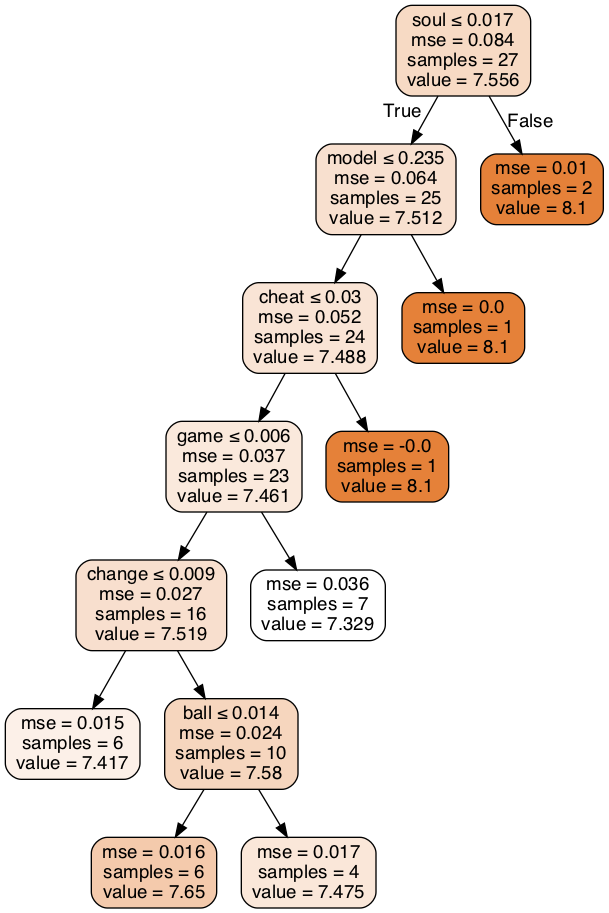

In [86]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(tree_est, out_file='boston_tree.dot',feature_names=satc_tfidf[satc_tfidf.columns[4:]].filter(features_words,axis=1).columns[0:],filled=True, 
                           rounded=True, special_characters=True)

with open('boston_tree.dot') as f:
    dot_graph = f.read()  
# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

In [87]:
feature_importances = pd.Series(data=tree.feature_importances_, index=list(satc_tfidf[satc_tfidf.columns[4:]].filter(features_words,axis=1)))
feature_importances.sort_values(axis=0, ascending=False)[0:15]

soul         0.367642
cheat        0.224781
model        0.206799
game         0.101130
change       0.057444
ball         0.042204
ovary        0.000000
sam          0.000000
jeremy       0.000000
rabbit       0.000000
sandwich     0.000000
postit       0.000000
jim          0.000000
honeymoon    0.000000
shrink       0.000000
dtype: float64

#### 50 Features, High Depth
We create a second model that splits up until "the end": We split as long as there are more then two samples at a node of the tree. We get a much more comprehensive image of the tree. 

In [89]:
tree2 = DecisionTreeRegressor(max_features=20, min_samples_split=2)
tree_est2 = tree2.fit(X_train, y_train)

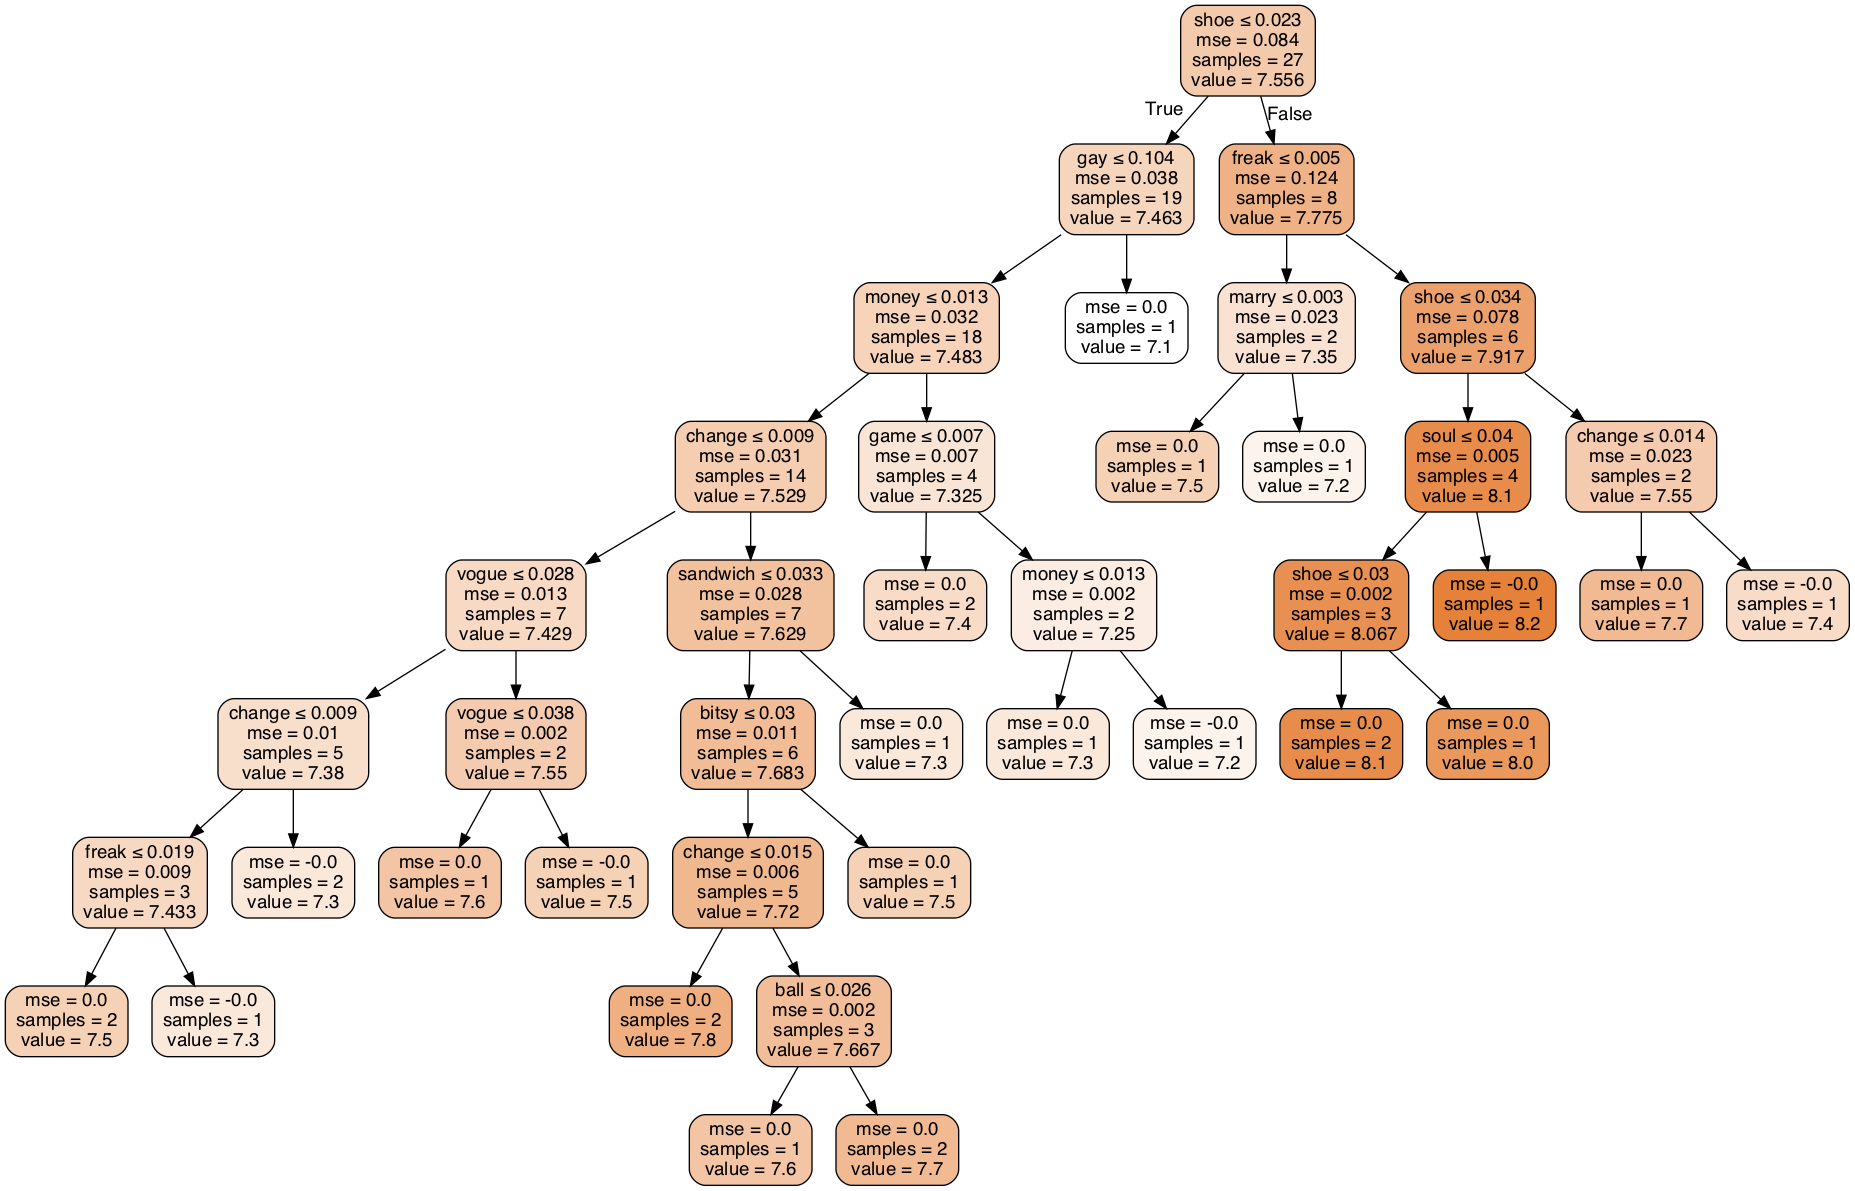

In [90]:
dot_data = export_graphviz(tree_est2, out_file='boston_tree.dot',feature_names=satc_tfidf[satc_tfidf.columns[4:]].filter(features_words,axis=1).columns[0:],filled=True, 
                           rounded=True, special_characters=True)

with open('boston_tree.dot') as f:
    dot_graph = f.read()  
I = graphviz.Source(dot_graph, format='png', engine='dot')
Image(I.render())

In [91]:
feature_importances2 = pd.Series(data=tree2.feature_importances_, index=list(satc_tfidf[satc_tfidf.columns[4:]].filter(features_words,axis=1)))
feature_importances2.sort_values(axis=0, ascending=False)[0:15]

shoe         0.422407
freak        0.224265
change       0.100441
gay          0.061416
money        0.059086
sandwich     0.055567
vogue        0.020420
marry        0.019853
bitsy        0.017794
game         0.009926
soul         0.005882
ball         0.002941
shrink       0.000000
jim          0.000000
honeymoon    0.000000
dtype: float64

Text(0, 0.5, 'y_star')

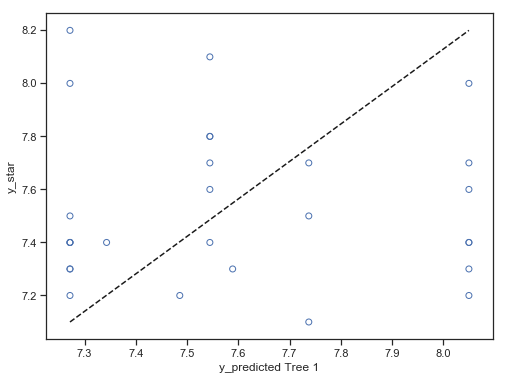

In [92]:
#EVALUATION of the two different trees including plots on 20 pca dimensions 
eval_tree1 = evaluate_model("tree",tree,900,20,satc_tfidf)
eval_tree2 = evaluate_model("tree2",tree2,900,20,satc_tfidf)

y_star1,y_pred1 = eval_tree1[2:4]
y_star2,y_pred2 = eval_tree2[2:4]

# Plot the predicted vs the actual medv response
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.scatter(y_pred1,y_star1 , facecolor='None', edgecolor='b')

ax.plot([min(y_pred1), max(y_pred1)], [min(y_star1), max(y_star1)], linestyle='--', color='k');
ax.set_xlabel('y_predicted Tree 1')
ax.set_ylabel('y_star')

Text(0, 0.5, 'y_star2')

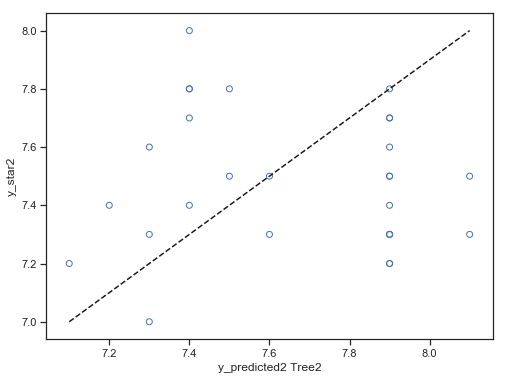

In [93]:
# Plot the predicted vs the actual medv response
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.scatter(y_pred2,y_star2 , facecolor='None', edgecolor='b')

ax.plot([min(y_pred2), max(y_pred2)], [min(y_star2), max(y_star2)], linestyle='--', color='k');
ax.set_xlabel('y_predicted2 Tree2')
ax.set_ylabel('y_star2')

In [94]:
print("The first Tree Model results in an MSE of " + str(eval_tree1[1][3]),
     "\nThe second Tree Model results in an MSE of " + str(eval_tree2[1][3]))

The first Tree Model results in an MSE of 0.0933661256377551 
The second Tree Model results in an MSE of 0.1252857142857142


### Random Forest Regressor <a class="anchor" id="randomforest"></a>

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 
Depending on the number of estimators (the number of trees that are averaged out) we get different results for the model. However, we don't get any results better then the MSE of around 0,05 that we have seen before. Plotting the predicted y shows that we still get a fairly bad prediction. 

Doing a grid search shows that don't see different MSE scores for chaning the number of estimators between 20 and 100. 

In [ ]:
randomforest = RandomForestRegressor(n_estimators=500)
randomforest_est =  randomforest.fit(X_train, y_train)

In [ ]:
# Get the predictors and the response values
X = satc_tfidf[satc_tfidf.columns[4:]].filter(features_words,axis=1).values
y = satc_tfidf['Rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=0)

y_pred = randomforest.predict(X_test)

# Plot the predicted vs the actual medv response
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.scatter(y_pred, y_test, facecolor='None', edgecolor='b')
# add a reference unity line
ax.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], linestyle='--', color='k');
ax.set_xlabel('y_predicted')
ax.set_ylabel('y_actual')

mse = np.mean((y_pred-y_test)**2)
print("MSE random forest, 200 esitmators = ", mse)

In [ ]:
#comparing different number of estimators shows we get almost the same MSE for any number of estimators in between 20 and 100 

In [ ]:
#gridsearch_randomforest= pd.DataFrame(columns=["Name","features","pca_dim",'MSE','MAbsE', 'Explained_variance_score','R_squared'])

#for pcadim in range(0,50,10):
 #   if pcadim == 0:
  #      pcadim = None 
   # for n_estimators in range(1,201,10):
    #    randomforest = RandomForestRegressor(n_estimators=n_estimators)
     #   gridsearch_randomforest.loc[len(gridsearch_randomforest)] = evaluate_model("randomforestst_"+str(n_estimators),randomforest,featuredim,pcadim,satc_tfidf)[1]

In [ ]:
#gridsearch_randomforest.sort_values("MSE", inplace=True)
#gridsearch_randomforest

### XG Boost <a class="anchor" id="xgb"></a>

As we are dealing with a weak regressor, we can use gradient boosting to create an ensemble of weak regression trees. 
XGBoost is a library that uses gradient boosting to achieve this. 

We are using XGBoost for this: XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. 

We get the best results for a tree with depth = 1, this corresponds to a simple linear regression. 

Test MSE =  0.042163645278340024


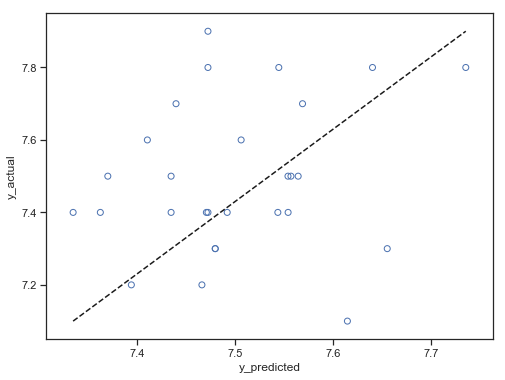

In [104]:
features_df = satc_tfidf[satc_tfidf.columns[4:]].filter(features_words,axis=1)
features = features_df.values
target_df = satc_tfidf['Rating']
target = target_df.values
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3)
test_df = pd.concat([target_df,features_df],axis=1)[0:60]
train_df = pd.concat([target_df,features_df],axis=1)[60:]
model = xgb.XGBRegressor(max_depth=1)
model.fit(features_train,target_train)
y_pred = model.predict(features_test)
y_test=target_test
# Plot the predicted vs the actual medv response
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.scatter(y_pred, y_test, facecolor='None', edgecolor='b')
# add a reference unity line
ax.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], linestyle='--', color='k');
ax.set_xlabel('y_predicted')
ax.set_ylabel('y_actual')

mse_ba = np.mean((y_pred-y_test)**2)
print("Test MSE = ", mse_ba)


In [119]:
gridsearch_xgb = pd.DataFrame(columns=["Name","features","pca_dim",'MSE','MAbsE', 'Explained_variance_score','R_squared'])

#pca dim should be in between 20 and 30 
featuredim = 500 
pcadim = 20
for pcadim in range(0,50,10):
    if pcadim == 0:
        pcadim = None 
    for depth in range(1,10):
        xgb_model = xgb.XGBRegressor(max_depth=depth)
        name = "xgb" + str(depth)
        gridsearch_xgb.loc[len(gridsearch_xgb)] = evaluate_model(name,xgb_model,featuredim,pcadim,satc_tfidf)[1]

In [124]:
gridsearch_xgb.sort_values("MSE", inplace=True)
gridsearch_xgb.head()

,Name,features,pca_dim,MSE,MAbsE,Explained_variance_score,R_squared
0,xgb1,500,None,0.058395,0.192117,-0.040790,-0.101503
18,xgb1,500,20,0.059186,0.199232,-0.059672,-0.140365
8,xgb9,500,None,0.061126,0.200492,-0.038606,-0.168427
3,xgb4,500,None,0.061785,0.200783,-0.054705,-0.088183
1,xgb2,500,None,0.062594,0.200767,-0.163116,-0.220563


### Prediction Including the Lines per Character <a class="anchor" id="lpc"></a>

We added four additional columns to the dataframe in order to take into account the lines spoken per character per episode. Plotting the lines spoken per person against their Ratings 

In [ ]:
satc_tfidf_LPC.head()
corr_carrie = satc_tfidf_LPC['Rating'].corr(satc_tfidf_LPC['lines_carrie'])
corr_miranda = satc_tfidf_LPC['Rating'].corr(satc_tfidf_LPC['lines_miranda'])
corr_charlotte = satc_tfidf_LPC['Rating'].corr(satc_tfidf_LPC['lines_charlotte'])
corr_samantha = satc_tfidf_LPC['Rating'].corr(satc_tfidf_LPC['lines_samantha'])

print("Correlation between the ratings and lines spoken by Samantha {corr_samantha}\n".format(corr_samantha=corr_samantha))
print("Correlation between the ratings and lines spoken by Miranda {corr_miranda}\n".format(corr_miranda=corr_miranda))
print("Correlation between the ratings and lines spoken by Charlotte {corr_charlotte}\n".format(corr_charlotte=corr_charlotte))
print("Correlation between the ratings and lines spoken by Carrie {corr_carrie}\n".format(corr_carrie=corr_carrie))


In [ ]:
satc_tfidf_LPC.plot(x="Rating",y="lines_carrie",kind="scatter",title="Number of Lines spoken by Carrie / Rating")
satc_tfidf_LPC.plot(x="Rating",y="lines_miranda",kind="scatter",title="Number of Lines spoken by Miranda / Rating")
satc_tfidf_LPC.plot(x="Rating",y="lines_charlotte",kind="scatter",title="Number of Lines spoken by Charlotte / Rating")
satc_tfidf_LPC.plot(x="Rating",y="lines_samantha",kind="scatter",title="Number of Lines spoken by Samantha / Rating")


### Model Comparison <a class="anchor" id="modelcomp"></a>

To conclude, we can say that it is not possible to predict the rating on IMDB based on the sripts. 95% of the ratings fall into a std of 0.28 +/- the mean of all ratings. We are not able to get a Mean Absolute Error of below ~0.19 - all of our prediction models are still predicting pretty much random outcomes. 

One of the reasons for this might be the narrow range in which we find the ratings of all episodes (all ratings lie between 7-8.8). It is also possible, that even though viewers liked episodes differently based on their content, they did not know how to express these differences in the rating. 

In [122]:
model_comparison_df = pd.DataFrame(columns=["Name","features","pca_dim",'MSE','MAbsE', 'Explained_variance_score','R_squared'])
#evaluate_model(model, number_of_features,pca_dim,df):

#get model scores, average of ten iterations 
#lasso = evaluate_model("lasso",lasso_model,50,50,satc_tfidf)[1]

#add to model comparison df 
#model_comparison_df.loc[len(model_comparison_df)] = lasso

### Linear Regression Models OLS
linear_regression = LinearRegression() 
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("linear_regression",linear_regression,500,20,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("linear_regression",linear_regression,500,10,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("linear_regression_LPC",linear_regression,500,20,satc_tfidf_LPC,True)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("linear_regression_LPC",linear_regression,500,10,satc_tfidf_LPC,True)[1]

### Lasso: We saw earlier that we get best results for 500 models, 10 PCA dim 
lasso_model = LassoCV()
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("lasso",lasso_model,500,10,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("lasso_LPC",lasso_model,500,10,satc_tfidf_LPC,True)[1]

### Decision Tree Regressors: We consider PCA Dimensions 10-30 and min splits 5 and 10 
tree_min10split = DecisionTreeRegressor(max_features=None, min_samples_split=10)
tree_min5split = DecisionTreeRegressor(max_features=None, min_samples_split=5)

model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("tree_min10split",tree_min10split,500,30,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("tree_min10split",tree_min10split,500,20,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("tree_min10split",tree_min10split,500,10,satc_tfidf)[1]

model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("tree_min5split",tree_min5split,500,30,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("tree_min5split",tree_min5split,500,20,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("tree_min5split",tree_min5split,500,10,satc_tfidf)[1]

model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("tree_min10split_LPC",tree_min10split,900,30,satc_tfidf_LPC,True)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("tree_min10split_LPC",tree_min10split,900,20,satc_tfidf_LPC,True)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("tree_min10split_LPC",tree_min10split,900,10,satc_tfidf_LPC,True)[1]

### Random Forest 
randomforest_500  = RandomForestRegressor(n_estimators=500)
randomforest_100  = RandomForestRegressor(n_estimators=100)

model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("randomForest_500",randomforest_500,500,20,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("randomForest_100",randomforest_100,500,20,satc_tfidf)[1]

model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("randomForest_500_LPC",randomforest_500,500,20,satc_tfidf_LPC,True)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("randomForest_100_LPC",randomforest_100,500,20,satc_tfidf_LPC,True)[1]

## XGB Boost 
xgb_1 = xgb.XGBRegressor(max_depth=1)
xgb_2 = xgb.XGBRegressor(max_depth=2)
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("xgb_depth=1",xgb_1,500,None,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("xgb_depth=2",xgb_2,500,None,satc_tfidf)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("xgb_depth=1_LPC",xgb_1,500,None,satc_tfidf_LPC,True)[1]
model_comparison_df.loc[len(model_comparison_df)] = evaluate_model("xgb_deoth=2_LPC",xgb_2,500,None,satc_tfidf_LPC,True)[1]


In [126]:
model_comparison_df.sort_values("MSE", inplace=True)
model_comparison_df.head()

,Name,features,pca_dim,MSE,MAbsE,Explained_variance_score,R_squared
5,lasso_LPC,500,10,0.057046,0.193371,-0.008712,-0.085281
1,linear_regression,500,10,0.058715,0.197696,-0.027516,-0.105596
3,linear_regression_LPC,500,10,0.058728,0.197130,-0.013800,-0.061237
19,xgb_depth=1,500,None,0.059999,0.197705,-0.040729,-0.110557
16,randomForest_100,500,20,0.060652,0.198568,-0.074411,-0.146658


## Episode Lookup <a class="anchor" id="keyword"></a>

In [121]:
my_q = 300 # to match dim of GNews word vectors
mcount = 1 # minimal word frequency  

w2v = Word2Vec(size = my_q, min_count = mcount)
w2v.build_vocab(list(satc_text_per_episode["all_text"]))

In [ ]:
w2v.intersect_word2vec_format("C:\\Users\\dorar_000\\Documents\\GoogleNews-vectors-negative300.bin.gz", binary = True)
#w2v.intersect_word2vec_format("/Users/robertaconrad/documents/07_Ecole_Polytechnique_Studienunterlagen/DataCampCapgemini/session7/GoogleNews-vectors-negative300.bin.gz", binary = True)

In [ ]:
def recommender(word):
    words = [word] +list(map(lambda x: x[0], w2v.similar_by_word(word)))
    weights = [1] + list( map(lambda x: x[1], w2v.similar_by_word(word)))

    reco = satc_tfidf.filter(words, axis=1).dot(weights).sort_values(ascending = False)[:10]
    
    ep_ids = eps.iloc[reco.index]['ID']
    
    #episodes =list(map(lambda x:ia.get_movie(x), ep_ids))
    
    for (i, index) in enumerate(list(reco.index)):
        
        print ("Recommendation {:.0f}: Season {:.0f}, Episode {:.0f}".format(i+1,eps.iloc[index]['Season'],eps.iloc[index]['Episode']))
        print (episodes[index].summary())
        print ()
        print ()
    

In [ ]:
## safe input handling KeyError Exception, and checking input is inside the vocab.
while True:
    try:
        word = input("Enter keyword: ")
        recommender(word)
        break
    except KeyError:
        print("word '%s' not in vocabulary" % word)
        continue
    